In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from io import open
from collections import Counter
from functools import partial
import unicodedata
import re
from torch.autograd import Variable
from gensim.models import KeyedVectors
import sacrebleu
import random
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Process Data

In [2]:
RESERVED_TOKENS = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, '<UNK>': 3}

In [3]:
def text2tokens(raw_text_fp, lang_type): 
    """ Takes filepath to raw text and outputs a list of lists, each representing a sentence of words (tokens) """
    with open(raw_text_fp) as f:
        tokens_data = [line.lower().split() for line in f.readlines()]
        if lang_type == 'source': 
            tokens_data = [datum + ['<EOS>'] for datum in tokens_data]
        elif lang_type == 'target': 
            tokens_data = [['<SOS'] + datum + ['<EOS>'] for datum in tokens_data]
    return tokens_data 

def load_word2vec(lang): 
    """ Loads pretrained vectors for a given language """
    filepath = "data/pretrained_word2vec/wiki.zh.vec".format(lang)
    word2vec = KeyedVectors.load_word2vec_format(filepath)
    return word2vec

def build_vocab(token_lists, max_vocab_size, word2vec): 
    """ Takes lists of tokens (representing sentences of words), max_vocab_size, word2vec model and returns: 
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices
        Note that the vocab will comprise N=max_vocab_size-len(RESERVED_TOKENS) tokens that are in word2vec model 
    """
    num_vocab = max_vocab_size - len(RESERVED_TOKENS)
    all_tokens = [token for sublist in token_lists for token in sublist]
    token_counter = Counter(all_tokens)
    token_counter_filtered = Counter({token: token_counter[token] for token in token_counter if token in word2vec})
    vocab, count = zip(*token_counter_filtered.most_common(num_vocab))
    id2token = list(RESERVED_TOKENS.keys()) + list(vocab)
    token2id = dict(zip(id2token, range(max_vocab_size)))
    return token2id, id2token 

def tokens2indices(tokens_data, token2id): 
    """ Takes tokenized data and token2id dictionary and returns indexed data """
    indices_data = [] 
    for datum in tokens_data: 
        indices_datum = [token2id[token] if token in token2id else RESERVED_TOKENS['<UNK>'] for token in datum ]
        indices_data.append(indices_datum)    
    return indices_data

def get_filepath(split, src_lang, targ_lang, lang_type): 
    """ Locates data filepath given data split type (train/dev/test), translation pairs (src_lang -> targ_lang), 
        and the language type (source or target)
    """
    folder_name = "data/iwslt-{}-{}/".format(src_lang, targ_lang)
    if lang_type == 'source': 
        file_name = "{}.tok.{}".format(split, src_lang)
    elif lang_type == 'target': 
        file_name = "{}.tok.{}".format(split, targ_lang)
    return folder_name + file_name 

def get_filepaths(src_lang, targ_lang): 
    """ Takes language names to be translated from and to (in_lang and out_lang respectively) as inputs, 
        returns a nested dictionary containing the filepaths for input/output data for train/dev/test sets  
    """
    fps = {} 
    for split in ['train', 'dev', 'test']: 
        fps[split] = {} 
        for lang_type in ['source', 'target']: 
            fps[split][lang_type] = {} 
            fps[split][lang_type]['filepath'] = get_filepath(split, src_lang, targ_lang, lang_type)
    return fps 

def process_data(src_lang, targ_lang, src_max_vocab_size, targ_max_vocab_size): 
    """ Takes source language and target language names and respective max vocab sizes as inputs 
        and returns as a nested dictionary containing: 
        - train_indices, val_indices, test_indices (as lists of source-target tuples)
        - train_tokens, val_tokens, test_tokens (as lists of source-target tuples)
        - source language's token2id and id2token 
        - target language's token2id and id2token
    """
    
    # get filepaths 
    data = get_filepaths(src_lang, targ_lang)
    
    # attach vocab sizes and word2vec models 
    data['train']['source']['max_vocab_size'] = src_max_vocab_size
    data['train']['target']['max_vocab_size'] = targ_max_vocab_size 
    data['train']['source']['word2vec'] = load_word2vec(src_lang) 
    data['train']['target']['word2vec'] = load_word2vec(targ_lang) 
    
    # loop through each file, read in text, convert to tokens, then to indices 
    for split in ['train', 'dev', 'test']: 
        for lang_type in ['source', 'target']: 
            
            # read in tokens 
            data[split][lang_type]['tokens'] = text2tokens(data[split][lang_type]['filepath'], lang_type)
            
            # build vocab from training data
            if split == 'train': 
                data['train'][lang_type]['token2id'], data['train'][lang_type]['id2token'] = build_vocab(
                    token_lists = data['train'][lang_type]['tokens'], 
                    max_vocab_size = data['train'][lang_type]['max_vocab_size'], 
                    word2vec = data['train'][lang_type]['word2vec']) 
                
            # convert tokens to indices 
            data[split][lang_type]['indices'] = tokens2indices(
                data[split][lang_type]['tokens'], data['train'][lang_type]['token2id'])
            
    return data

In [4]:
SRC_VOCAB_SIZE = 1000
TARG_VOCAB_SIZE = 1000

In [5]:
data = process_data('zh', 'en', src_max_vocab_size=SRC_VOCAB_SIZE, targ_max_vocab_size=TARG_VOCAB_SIZE)

In [6]:
# print example for sanity check  
print("Example Source: {}".format(data['train']['source']['tokens'][5]))
print("Example Target: {}".format(data['train']['target']['tokens'][5]))

Example Source: ['你', '现在', '可以', '去', '个', '真正', '的', '学校', '念书', '了', '他', '说', '<EOS>']
Example Target: ['<SOS', '&quot;', 'you', 'can', 'go', 'to', 'a', 'real', 'school', 'now', ',', '&quot;', 'he', 'said', '.', '<EOS>']


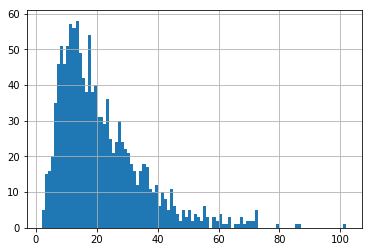

In [7]:
# check distribution of source sentence lengths 
pd.Series(np.array([len(l) for l in data['train']['source']['indices']])).hist(bins=100);

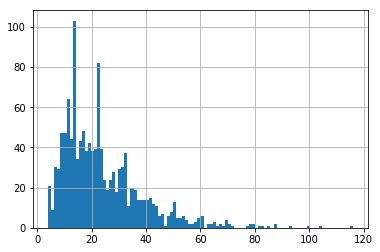

In [8]:
# check distribution of target sentence lengths 
pd.Series(np.array([len(l) for l in data['train']['target']['indices']])).hist(bins=100); 

# Create Data Loaders

In [9]:
class TranslationDataset(Dataset): 
    """ 
    Class that represents a train/validation/test/dataset that's readable for Pytorch. 
    Note that this class inherits torch.utils.data.Dataset
    """
    def __init__(self, src_indices, targ_indices, src_max_sentence_len, targ_max_sentence_len):
        """ 
        Initialize dataset by passing in a list of input indices and a list of output indices 
        """
        self.src_indices = src_indices
        self.targ_indices = targ_indices
        self.src_max_sentence_len = src_max_sentence_len
        self.targ_max_sentence_len = targ_max_sentence_len
        assert (len(self.src_indices) == len(self.targ_indices))
        
    def __len__(self): 
        return len(self.src_indices)
    
    def __getitem__(self, key): 
        """ 
        Triggered when dataset[i] is called, outputs lists of input and output indices, as well as their 
        respective lengths
        """
        src_idx = self.src_indices[key][:self.src_max_sentence_len]
        src_len = len(src_idx)
        targ_idx = self.targ_indices[key][:self.targ_max_sentence_len]
        targ_len = len(targ_idx)
        return [src_idx, targ_idx, src_len, targ_len]
    
def collate_func(src_max_sentence_len, targ_max_sentence_len, batch): 
    """ Customized function for DataLoader that dynamically pads the batch so that all data have the same length"""
    
    src_idxs = [] 
    targ_idxs = [] 
    src_lens = [] 
    targ_lens = [] 
    
    for datum in batch: 
        # append original lengths of sequences 
        src_lens.append(datum[2]) 
        targ_lens.append(datum[3])
        
        # pad sequences before appending 
        src_idx_padded = np.pad(array=np.array(datum[0]), pad_width = ((0, src_max_sentence_len - datum[2])), 
                                mode='constant', constant_values=RESERVED_TOKENS['<PAD>'])
        targ_idx_padded = np.pad(array=np.array(datum[1]), pad_width = ((0, targ_max_sentence_len - datum[3])),
                                 mode='constant', constant_values=RESERVED_TOKENS['<PAD>'])
        src_idxs.append(src_idx_padded)
        targ_idxs.append(targ_idx_padded)
    
    return [torch.from_numpy(np.array(src_idxs)), torch.from_numpy(np.array(targ_idxs)), 
            torch.LongTensor(src_lens), torch.LongTensor(targ_lens)]

def create_dataloaders(processed_data, src_max_sentence_len, targ_max_sentence_len, batch_size): 
    """ Takes processed_data as dictionary output from process_data func, maximum sentence lengths, 
        and outputs train_loader, dev_loader, and test_loaders 
    """
    loaders = {} 
    for split in ['train', 'dev', 'test']: 
        dataset = TranslationDataset(data[split]['source']['indices'], data[split]['target']['indices'], 
                                     src_max_sentence_len, targ_max_sentence_len)
        loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=False, 
                                    collate_fn=partial(collate_func, src_max_sentence_len, targ_max_sentence_len))
    return loaders['train'], loaders['dev'], loaders['test']

In [10]:
BATCH_SIZE = 16
SRC_MAX_SENTENCE_LEN = 40 
TARG_MAX_SENTENCE_LEN = 40

In [11]:
train_loader, dev_loader, test_loader = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
train_loader_, dev_loader_, test_loader_ = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, 1000)

In [12]:
# check that loader works 
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
    print(i)
    print(src_idxs.size())
    print(src_idxs)
    print(src_lens)
    print(targ_idxs.size())
    print(targ_idxs)
    print(targ_lens)
    break 

0
torch.Size([16, 40])
tensor([[  5,   3, 171,   3, 409,   3, 184, 928,   3, 929, 361,  18,   3,   4,
         327,   1,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2],
        [  5,   4, 199,   7,  70,  13,   4,   3, 200,   3,   3, 612,   3, 521,
           1,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2],
        [ 13,   3,   3,   3,   3,  15,   3,   3,  28, 522, 523, 233,   4, 521,
          25, 261,  19, 201,  13, 732,   1,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2],
        [  3,   3, 234,   8, 199,   3, 216,  48,   1,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
           2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2],
        [  5, 137,  53,  83, 287,   3,  29,  45,   5,  23, 930, 1

# Model Architecture

In [13]:
def get_pretrained_emb(word2vec, token2id): 
    """ Given word2vec model and the vocab's token2id, extract pretrained word embeddings """
    pretrained_emb = np.zeros((len(token2id), 300)) 
    for token in token2id: 
        try: 
            pretrained_emb[token2id[token]] = word2vec[token]
        except: 
            pretrained_emb[token2id[token]] = np.random.normal(size=(300,))
    return torch.from_numpy(pretrained_emb.astype(np.float32)).to(device)

In [115]:
# class EncoderRNN(nn.Module):
#     def __init__(self, enc_input_dim, enc_embed_dim, enc_hidden_dim, pretrained_word2vec): 
#         super(EncoderRNN, self).__init__()
#         self.enc_input_dim = enc_input_dim 
#         self.enc_embed_dim = enc_embed_dim 
#         self.enc_hidden_dim = enc_hidden_dim 
#         self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
#         self.gru = nn.GRU(input_size=enc_embed_dim, hidden_size=enc_hidden_dim, num_layers=1, bidirectional=True)
    
#     def forward(self, enc_input, enc_input_lens):
#         batch_size = enc_input.size()[0]
#         _, idx_sort = torch.sort(enc_input_lens, dim=0, descending=True)
#         _, idx_unsort = torch.sort(idx_sort, dim=0)
#         enc_input, enc_input_lens = enc_input.index_select(0, idx_sort), enc_input_lens.index_select(0, idx_sort)
#         embedded = self.embedding(enc_input)
#         embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, enc_input_lens, batch_first=True)
#         hidden = self.initHidden(batch_size).to(device)
#         output, hidden = self.gru(embedded, hidden)
#         output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, 
#                                                            total_length=SRC_MAX_SENTENCE_LEN,
#                                                            padding_value=RESERVED_TOKENS['<PAD>'])
#         output = output.index_select(0, idx_unsort)
#         final_hidden = torch.cat([output[:, -1, :self.enc_hidden_dim], 
#                                   output[:, 0, self.enc_hidden_dim:]], dim=1).unsqueeze(0) 
#         return output, final_hidden

#     def initHidden(self, batch_size):
#         return torch.zeros(2, batch_size, self.enc_hidden_dim, device=device)
    
# class DecoderRNN(nn.Module):
#     def __init__(self, dec_input_dim, dec_embed_dim, dec_hidden_dim, pretrained_word2vec):
#         super(DecoderRNN, self).__init__()
#         self.dec_input_dim = dec_input_dim
#         self.dec_embed_dim = dec_embed_dim
#         self.dec_hidden_dim = dec_hidden_dim 
#         self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
#         self.gru = nn.GRU(dec_embed_dim, dec_hidden_dim)
#         self.out = nn.Linear(dec_hidden_dim, dec_input_dim)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, dec_input, dec_hidden): 
#         batch_size = dec_input.size()[0]
#         embedded = self.embedding(dec_input).view(1, batch_size, -1)
#         output, hidden = self.gru(embedded, dec_hidden)
#         output = self.softmax(self.out(output[0]))    
#         return output, hidden
    
# class EncoderDecoder(nn.Module): 
#     def __init__(self, encoder, decoder, decoder_token2id): 
#         super(EncoderDecoder, self).__init__() 
#         self.encoder = encoder 
#         self.decoder = decoder 
#         self.output_dim = self.decoder.dec_input_dim
#         self.output_seq_len = TARG_MAX_SENTENCE_LEN
        
#     def forward(self, src_idx, targ_idx, src_lens, targ_lens, teacher_forcing_ratio): 
#         batch_size = src_idx.size()[0]
#         enc_output, enc_hidden = self.encoder(src_idx, src_lens)
#         dec_hidden = enc_hidden 
#         dec_outputs = Variable(torch.zeros(self.output_seq_len, batch_size, self.output_dim))
#         hypotheses = Variable(torch.zeros(self.output_seq_len, batch_size))
#         dec_output = targ_idx[:, 0] # initialize with <SOS>
#         for di in range(1, self.output_seq_len): 
#             dec_output, dec_hidden = self.decoder(dec_output, dec_hidden)
#             dec_outputs[di] = dec_output 
#             teacher_labels = targ_idx[:, di-1] 
#             greedy_labels = dec_output.data.max(1)[1]
#             dec_output = teacher_labels if random.random() < teacher_forcing_ratio else greedy_labels 
#             hypotheses[di] = greedy_labels

#         return dec_outputs, hypotheses.transpose(0,1)


In [116]:
# with context vector 

class EncoderRNN(nn.Module):
    def __init__(self, enc_input_dim, enc_embed_dim, enc_hidden_dim, pretrained_word2vec): 
        super(EncoderRNN, self).__init__()
        self.enc_input_dim = enc_input_dim 
        self.enc_embed_dim = enc_embed_dim 
        self.enc_hidden_dim = enc_hidden_dim 
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
        self.gru = nn.GRU(input_size=enc_embed_dim, hidden_size=enc_hidden_dim, num_layers=1, 
                          batch_first=True, bidirectional=True)
    
    def forward(self, enc_input, enc_input_lens):
        batch_size = enc_input.size()[0]
        _, idx_sort = torch.sort(enc_input_lens, dim=0, descending=True)
        _, idx_unsort = torch.sort(idx_sort, dim=0)
        enc_input, enc_input_lens = enc_input.index_select(0, idx_sort), enc_input_lens.index_select(0, idx_sort)
        embedded = self.embedding(enc_input)
        embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, enc_input_lens, batch_first=True)
        hidden = self.initHidden(batch_size).to(device)
        output, hidden = self.gru(embedded, hidden)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, 
                                                           total_length=SRC_MAX_SENTENCE_LEN,
                                                           padding_value=RESERVED_TOKENS['<PAD>'])
        output = output.index_select(0, idx_unsort)
        final_hidden = torch.cat([output[:, -1, :self.enc_hidden_dim], 
                                  output[:, 0, self.enc_hidden_dim:]], dim=1).unsqueeze(0) 
        return output, final_hidden

    def initHidden(self, batch_size):
        return torch.zeros(2, batch_size, self.enc_hidden_dim, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, dec_input_dim, dec_embed_dim, dec_hidden_dim, enc_hidden_dim, pretrained_word2vec):
        super(DecoderRNN, self).__init__()
        self.dec_input_dim = dec_input_dim
        self.dec_embed_dim = dec_embed_dim
        self.dec_hidden_dim = dec_hidden_dim 
        self.enc_hidden_dim = enc_hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
        self.gru = nn.GRU(dec_embed_dim + enc_hidden_dim, dec_hidden_dim)
        self.out = nn.Linear(dec_hidden_dim, dec_input_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, dec_input, dec_hidden, enc_outputs): 
        batch_size = dec_input.size()[0]
        embedded = self.embedding(dec_input).view(1, batch_size, -1)
        context = torch.cat([enc_outputs[:, -1, :self.enc_hidden_dim], 
                             enc_outputs[:, 0, self.enc_hidden_dim:]], dim=1).unsqueeze(0)
        concat = torch.cat([embedded, context], 2)
        output, hidden = self.gru(concat, dec_hidden)
        output = self.softmax(self.out(output[0]))    
        return output, hidden
        
class EncoderDecoder(nn.Module): 
    def __init__(self, encoder, decoder, decoder_token2id): 
        super(EncoderDecoder, self).__init__() 
        self.encoder = encoder 
        self.decoder = decoder 
        self.output_dim = self.decoder.dec_input_dim
        self.output_seq_len = TARG_MAX_SENTENCE_LEN

    def forward(self, src_idx, targ_idx, src_lens, targ_lens, teacher_forcing_ratio): 
        batch_size = src_idx.size()[0]
        enc_outputs, enc_hidden = self.encoder(src_idx, src_lens)
        dec_hidden = enc_hidden 
        dec_outputs = Variable(torch.zeros(self.output_seq_len, batch_size, self.output_dim))
        hypotheses = Variable(torch.zeros(self.output_seq_len, batch_size))
        dec_output = targ_idx[:, 0] # initialize with <SOS>
        for di in range(1, self.output_seq_len): 
            dec_output, dec_hidden = self.decoder(dec_output, dec_hidden, enc_outputs)
            dec_outputs[di] = dec_output 
            teacher_labels = targ_idx[:, di-1] 
            greedy_labels = dec_output.data.max(1)[1]
            dec_output = teacher_labels if random.random() < teacher_forcing_ratio else greedy_labels 
            hypotheses[di] = greedy_labels

        return dec_outputs, hypotheses.transpose(0,1)

In [117]:
# with attention 

class Attention(nn.Module): 
    
    """ Implements the attention mechanism by Bahdanau et al. (2015) """
    
    def __init__(self, enc_hidden_dim, dec_hidden_dim): 
        super(Attention, self).__init__() 
        self.num_annotations = enc_hidden_dim
        self.input_dim = enc_hidden_dim * 2 + dec_hidden_dim
        self.attn = nn.Linear(self.input_dim, self.num_annotations)
        self.v = nn.Parameter(torch.rand(self.num_annotations))
        
    def forward(self, encoder_outputs, last_dec_hidden): 
        batch_size = encoder_outputs.size()[0]
        hidden_broadcast = last_dec_hidden.repeat(1, self.num_annotations, 1)
        v_broadcast = v.repeat(batch_size, self.num_annotations, self.input_dim)
        concat = torch.cat([encoder_outputs, hidden_broadcast], dim=2)
        energies = torch.bmm(v_broadcast, torch.nn.Tanh(self.attn(concat))) 
        attn_weights = F.softmax(energies, dim=2).squeeze(1)
        return attn_weights

class DecoderAttnRNN(nn.Module):
    def __init__(self, dec_input_dim, dec_embed_dim, dec_hidden_dim, enc_hidden_dim, pretrained_word2vec):
        super(DecoderAttnRNN, self).__init__()
        self.dec_input_dim = dec_input_dim
        self.dec_embed_dim = dec_embed_dim
        self.dec_hidden_dim = dec_hidden_dim 
        self.enc_hidden_dim = enc_hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
        self.attn = nn.Linear(self.enc_hidden_dim * 2, self.enc_hidden_dim)
        self.gru = nn.GRU(dec_embed_dim + enc_hidden_dim, dec_hidden_dim)
        self.out = nn.Linear(dec_hidden_dim, dec_input_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, dec_input, dec_hidden, enc_outputs): 
        batch_size = dec_input.size()[0]
        embedded = self.embedding(dec_input).view(1, batch_size, -1)
        context = torch.cat([enc_outputs[:, -1, :self.enc_hidden_dim], 
                             enc_outputs[:, 0, self.enc_hidden_dim:]], dim=1).unsqueeze(0)
        concat = torch.cat([embedded, context], 2)
        output, hidden = self.gru(concat, dec_hidden)
        output = self.softmax(self.out(output[0]))    
        return output, hidden

# Train and Evaluate

In [118]:
def tensor2corpus(tensor, id2token): 
    """ Takes a tensor (num_sentences x max_sentence_length) representing the corpus, 
        returns its string equivalent 
    """
    tensor = tensor.view(-1)
    ignored_idx = [RESERVED_TOKENS[token] for token in ['<SOS>', '<EOS>', '<PAD>']] 
    filtered_list = [id2token[idx] for idx in tensor.numpy().astype(int).tolist() if idx not in ignored_idx] 
    corpus = ' '.join(filtered_list)
    return corpus 

In [119]:
def evaluate(model, loader, id2token): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    
    model.eval() 
    criterion = nn.NLLLoss()
    total_loss = 0 
    reference_corpus = []
    hypothesis_corpus = [] 
    
    for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(loader): 
        batch_size = src_idxs.size()[0]
        outputs, hypotheses = model(src_idxs, targ_idxs, src_lens, targ_lens, teacher_forcing_ratio=0.0)
        outputs = outputs[1:].view(-1, TARG_VOCAB_SIZE)
        targets = targ_idxs[:,1:]
        hypothesis_corpus.append(hypotheses)
        reference_corpus.append(targets)
 
        loss = F.nll_loss(outputs.view(-1, TARG_VOCAB_SIZE), targets.contiguous().view(-1), 
                          ignore_index=RESERVED_TOKENS['<PAD>'])
        total_loss += loss.item()  

    # reconstruct corpus and compute bleu score 
    hypothesis_corpus = torch.cat(hypothesis_corpus, dim=0) 
    reference_corpus = torch.cat(reference_corpus, dim=0)
    hypothesis_corpus = tensor2corpus(hypothesis_corpus, id2token)
    reference_corpus = tensor2corpus(reference_corpus, id2token)
    bleu_score = sacrebleu.corpus_bleu(hypothesis_corpus, reference_corpus).score
    
    return total_loss / len(loader), bleu_score, hypothesis_corpus

In [120]:
def train(model, train_loader, dev_loader, id2token, learning_rate, num_epochs=3, 
          print_intermediate=True, save_checkpoint=False, model_name='default'): 
    
    # initialize optimizer and criterion 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index=RESERVED_TOKENS['<PAD>'])
    results = [] 
    
    # loop through train data in batches and train 
    for epoch in range(num_epochs): 
        train_loss = 0 
        for batch, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            final_outputs, hypotheses = model(src_idxs, targ_idxs, src_lens, targ_lens, teacher_forcing_ratio=0.5) 
            loss = criterion(final_outputs[1:].view(-1, TARG_VOCAB_SIZE), targ_idxs[:,1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            
            if batch % 10 == 0 or ((epoch==num_epochs-1) & (batch==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + batch / len(train_loader)
                result['train_loss'], result['train_bleu'], train_hypotheses = evaluate(model, train_loader, id2token) 
                result['val_loss'], result['val_bleu'], val_hypotheses = evaluate(model, dev_loader, id2token)
                results.append(result)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Loss: {:.2f}, Val Loss: {:.2f}, Train BLEU: {:.2f}, Val BLEU: {:.2f}'\
                          .format(result['epoch'], result['train_loss'], result['val_loss'], 
                                  result['train_bleu'], result['val_bleu']))

In [121]:
encoder = EncoderRNN(enc_input_dim=SRC_VOCAB_SIZE, enc_embed_dim=300, enc_hidden_dim=300, 
                     pretrained_word2vec=get_pretrained_emb(data['train']['source']['word2vec'],
                                                            data['train']['source']['token2id']))
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader): 
    if i == 10: 
        enc_outputs, enc_final_hidden = encoder(src_idxs, src_lens)
        print("enc_outputs size is {}".format(enc_outputs.size()))
        print("enc_final_hidden size is {}".format(enc_final_hidden.size()))
        break 

enc_outputs size is torch.Size([16, 40, 600])
enc_final_hidden size is torch.Size([1, 16, 600])


In [122]:
encoder = EncoderRNN(enc_input_dim=SRC_VOCAB_SIZE, enc_embed_dim=300, enc_hidden_dim=300, 
                     pretrained_word2vec=get_pretrained_emb(data['train']['source']['word2vec'],
                                                            data['train']['source']['token2id']))
decoder = DecoderRNN(dec_input_dim=TARG_VOCAB_SIZE, dec_embed_dim=300, dec_hidden_dim=2*300, enc_hidden_dim=2*300, # fix 
                     pretrained_word2vec=get_pretrained_emb(data['train']['target']['word2vec'], 
                                                            data['train']['target']['token2id']))
model = EncoderDecoder(encoder, decoder, data['train']['target']['token2id'])
train(model, train_loader, dev_loader, data['train']['target']['id2token'], learning_rate=0.0005) 

Epoch: 0.00, Train Loss: 6.11, Val Loss: 5.86, Train BLEU: 4.24, Val BLEU: 5.09
Epoch: 0.13, Train Loss: 5.06, Val Loss: 4.73, Train BLEU: 3.89, Val BLEU: 4.94
Epoch: 0.25, Train Loss: 5.05, Val Loss: 4.63, Train BLEU: 3.89, Val BLEU: 4.94
Epoch: 0.38, Train Loss: 5.02, Val Loss: 4.63, Train BLEU: 3.89, Val BLEU: 4.94
Epoch: 0.51, Train Loss: 4.97, Val Loss: 4.58, Train BLEU: 3.89, Val BLEU: 4.94
Epoch: 0.63, Train Loss: 4.95, Val Loss: 4.61, Train BLEU: 3.89, Val BLEU: 4.94


KeyboardInterrupt: 